# 1. MUSICAL KEY CLASSIFICATION

High-level steps:

1. Create train, validation and test sets
2. Build the neural network
3. Train the neural network
4. Evaluate the neural network on the test set
5. Make predictions on a new sample

In [2]:
import import_ipynb
N = import_ipynb.NotebookLoader(path=['.'])
N.load_module("Functions")
from Functions import *

importing Jupyter notebook from .\Functions.ipynb


# Important values

In [3]:
annotations_file  = 'storage/musicalKeyClassificiation.csv'
audio_folder = 'storage/audioForMusicalKeyClassification'
spectrograms_storage_file_name = 'storage/musicalKeyClassificationSpectrograms.npy'
melspectrograms_storage_file_name = 'storage/musicalKeyClassificationMelspectrograms.npy'
num_classes = None # Assigned later
segments_per_file = 10

# Obtain data

## Mapping between musical keys & integers
This is for creating target values amenable to 1-hot encoding, which in turn helps in training...

In [4]:
# Mapping each possible musical key to an integer:
keys = ['Ab', 'A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G']
map, i = {}, 0
for k in keys:
    map[k + ' major'] = i
    map[k + ' minor'] = i + 12
    i += 1

# Printing the mapping:
for key in map: print(f'{key}: {map[key]}')

Ab major: 0
Ab minor: 12
A major: 1
A minor: 13
Bb major: 2
Bb minor: 14
B major: 3
B minor: 15
C major: 4
C minor: 16
Db major: 5
Db minor: 17
D major: 6
D minor: 18
Eb major: 7
Eb minor: 19
E major: 8
E minor: 20
F major: 9
F minor: 21
Gb major: 10
Gb minor: 22
G major: 11
G minor: 23


**_Hence, note that we have a total of 24 possible target classes._**

In [5]:
num_classes = 24

## Ground truth

In [6]:
# Seeing some rows of the dataset:
df = pd.read_csv(annotations_file, header=0)
df.head(5)

,TRACK,SOURCE,GLOBAL KEY,BEATPORT KEY,SUBGENRE,AUDIO LINK,ARTIST,TRACK.1
0,10089,endo_b,D major,D major,breaks,http://geo-samples.beatport.com/lofi/10089.LOF...,Jason Sparks,Close My Eyes
1,61415,forum,F minor,F major,trance,http://geo-samples.beatport.com/lofi/61415.LOF...,NaN,NaN
2,74982,forum,C minor,A minor,trance,http://geo-samples.beatport.com/lofi/74982.LOF...,NaN,NaN
3,101069,forum,E minor,A major,electro-house,http://geo-samples.beatport.com/lofi/101069.LO...,NaN,NaN
4,190477,forum,D minor,D major,breaks,http://geo-samples.beatport.com/lofi/190477.LO...,NaN,NaN


In [7]:
# Picking out only the relevant data:
df = df.drop(['SOURCE', 'BEATPORT KEY', 'SUBGENRE', 'AUDIO LINK', 'ARTIST', 'TRACK.1'], axis=1)
df.head(5)

,TRACK,GLOBAL KEY
0,10089,D major
1,61415,F minor
2,74982,C minor
3,101069,E minor
4,190477,D minor


Adding a column to indicate target value (this helps in 1-hot encoding, which in turn helps in training)...

In [8]:
# Appending a new column to contain the target values obtained previously:
target = []
for value in df['GLOBAL KEY']: target.append(map[value])
df['TARGET'] = target
df.head(5)

,TRACK,GLOBAL KEY,TARGET
0,10089,D major,6
1,61415,F minor,21
2,74982,C minor,16
3,101069,E minor,20
4,190477,D minor,18


# Preparing datasets

Obtaining melspectrograms for each audio file...

In [9]:
audio_params, data = get_all_melspectrograms(df,
                                             audio_folder,
                                             spectrograms_storage_file_name,
                                             melspectrograms_storage_file_name,
                                             segments_per_file=segments_per_file,
                                             n_mels=128)

Regenerate spectrograms? No
Regenerate melspectrograms? No


In [10]:
for key in audio_params: print(f'{key}: {audio_params[key]}')

segments_per_file: 10
sr: 44100
n_fft: 2048
hop_length: 512
n_mels: 128
n_frames: 2000


Checking the items in `data` (for verifying the code's success)...

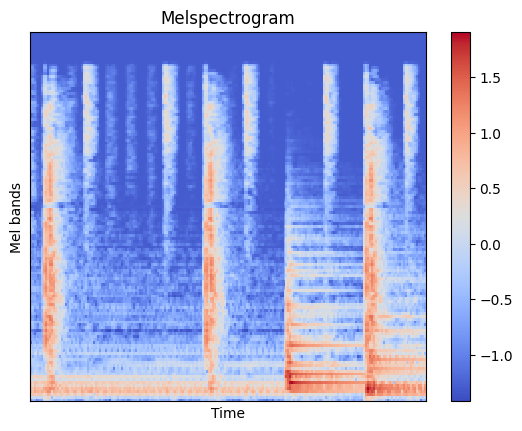

In [11]:
# Checking a random melspectrogram from `data`...
get_random_melspectrogram(data)

Obtaining the data to be used for training and testing of neural networks...

In [12]:
data_params, data_and_labels, train_dataset, validation_dataset = get_data(df,
                                                                           data,
                                                                           num_classes,
                                                                           segments_per_file=segments_per_file,
                                                                           validation_start=0.9,
                                                                           batch_size=32)

Training data shape = (5436, 128, 200), Validation data shape = (604, 128, 200)


In [13]:
for key in data_params: print(f'{key}: {data_params[key]}')

segments_per_file: 10
validation_start: 0.9
num_classes: 24
batch_size: 32


# Building & training the CNN

## Defining the CNN architecture
Note that in Keras, the first layer in any sequential model (initialised using `keras.Sequential`) must specify the input shape. Once this input shape is specified, Keras will automatically infer the shapes of inputs for later layers.

In [68]:
# Function to generate CNN model...
def get_model(input_shape=(audio_params['n_mels'], audio_params['n_frames'] // data_params['segments_per_file'], 1)):
    '''
    Input parameters:
    - `input_shape (tuple)`: Shape of input set

    Return values:
    - `model`: CNN model
    '''

    # BUILD MODEL TOPOLOGY
    
    model = keras.Sequential([
        keras.layers.Input(input_shape),
        #________________________
        # CONVOLUTIONAL LAYERS
        # Convolutional layer 1:
        keras.layers.Conv2D(8, (5, 5), padding='valid', activation='elu'),
        # Convolutional layer 2:
        keras.layers.Conv2D(8, (5, 5), padding='valid', activation='elu'),
        # Convolutional layer 3:
        keras.layers.Conv2D(8, (5, 5), padding='valid', activation='elu'),
        # Convolutional layer 4:
        keras.layers.Conv2D(8, (5, 5), padding='valid', activation='elu'),
        # Convolutional layer 5:
        keras.layers.Conv2D(8, (5, 5), padding='valid', activation='elu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.2),
        #________________________
        # DENSE LAYERS
        # Flatten output and feed it into dense layer:
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(48, activation='elu'),
        #________________________
        # OUTPUT LAYER
        keras.layers.Dense(num_classes, activation='softmax')])
    
    #------------------------------------
    # COMPILING MODEL WITH APPROPRIATE LOSS AND OPTIMIZER

    # Optimizer:
    optimizer = keras.optimizers.SGD(
        learning_rate=0.001,
        momentum=0.9,
        weight_decay=0.0001)
    # Loss function:
    loss = keras.losses.CategoricalCrossentropy()
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy'])

    return model

**NOTE: Valid padding for convolutional layers**:

Valid padding is a technique used in convolutional neural networks (CNNs) to process the input data without adding any additional rows or columns of pixels around the edges of the data. This means that the size of the output feature map is smaller than the size of the input data. Valid padding is used when it is desired to reduce the size of the output feature map in order to reduce the number of parameters in the model and improve its computational efficiency.
> REFERENCE: https://www.geeksforgeeks.org/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max_pool-of-tensorflow/


Checking the model's architecture...

In [69]:
model = get_model()
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)                   │ (None, 124, 196, 8)         │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 120, 192, 8)         │           1,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 116, 188, 8)         │           1,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 112, 184, 8)         │           1,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 108, 180, 8)         │           1,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 54, 90, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 54, 90, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 38880)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 38880)               │         155,520 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 48)                  │       1,866,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 24)                  │           1,176 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,029,624 (7.74 MB)

 Trainable params: 1,951,864 (7.45 MB)

 Non-trainable params: 77,760 (303.75 KB)

## Defining customised performance function
Customised performance function to account for distance from correct label...

**NOTE: Categories of predictions**:

- **Correct**: if the tonic and the mode (major/minor) of prediction and target correspond
- **Fifth**: if the tonic of the prediction is the fifth of the target (or vice versa), and modes correspond
- **Relative Minor/Major**: if modes differ and either one of the following is true:
    - The predicted mode is minor and the predicted tonic is 3 semitones below the target
    - The predicted mode is major and the predicted tonic is 3 semitones above the target
- **Parallel Minor/Major**: if modes differ but the predicted tonic matches the target
- **Other**: Prediction errors not caught by any category, i.e. the most severe errors

Now, note that in the current key-to-integer mapping, we have the following:

- key $<$ 12 means major
- key $\geq$ 12 means minor
- If key $<$ 12, key + 12 is the minor version of the same key
- If key $\geq$ 12, key - 12 is the major version of the same key

**NOTE: Performance calculation**:

We first compute the ratio of predictions that fall into each category. We then calculate the MIREX weighted score as:

$w = r_c + 0.5 \cdot r_f + 0.3 \cdot r_r + 0.2 \cdot r_p$

Here, $r_c$, $r_f$ , $r_r$ and $r_p$ are the ratios of the correct, fifth, relative minor/major and parallel minor/major respectively.

In [70]:
def get_performance(model, data, labels):
    # Computing the ratios of predictions lying in the following categories:
    r_c = r_f = r_r = r_p = other = float(0)
    n = float(len(data))

    predictions = np.argmax(model(data), axis=1)
    # NOTE: `model.predict(x)` returns a vector whose maximum value's index corresponds to the predicted target value

    for y_pred, y_true in zip(predictions, labels):
        # Classifying the predictions:
        if y_pred == y_true:
            r_c += 1
        elif y_pred == y_true - 5 or y_pred == y_true + 7:
            r_f += 1
        elif (y_pred >= 12 and y_pred == y_true - 3 + 12) or (y_pred < 12 and y_pred == y_true + 3 - 12):
            r_r += 1
        elif y_pred == y_true - 12 or y_pred == y_true + 12:
            r_p += 1
        else:
            other += 1

    r_c, r_f, r_r, r_p = r_c/n, r_f/n, r_r/n, r_p/n
    return r_c + 0.5*r_f + 0.3*r_r + 0.2*r_p

## Training the CNN
### APPROACH 1: Use of predefined training functions (for demonstration purposes)
Using predefined methods of `tensorflow.keras.Model`.

> REFERENCES:
> - https://victorzhou.com/blog/keras-cnn-tutorial/
> - https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [71]:
# Code needed to log training history:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('musicalKeyClassificationTraining.log', separator=',', append=False)

# Building model:
model = get_model()

# Training model:
print('TRAINING')
history = model.fit(
    train_dataset,
    epochs=10,
    batch_size=data_params['batch_size'],
    validation_data=validation_dataset,
    verbose=True,
    callbacks=[csv_logger])

TRAINING
Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.1780 - loss: 3.3791 - val_accuracy: 0.3113 - val_loss: 2.4541
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 26s 152ms/step - accuracy: 0.5605 - loss: 1.5320 - val_accuracy: 0.4503 - val_loss: 1.8836
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.8468 - loss: 0.5527 - val_accuracy: 0.4868 - val_loss: 1.8478
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - accuracy: 0.9606 - loss: 0.2079 - val_accuracy: 0.5265 - val_loss: 1.7695
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.9918 - loss: 0.0986 - val_accuracy: 0.5397 - val_loss: 1.7806
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.9976 - loss: 0.0555 - val_accuracy: 0.5381 - val_loss: 1.7665
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.9992 - loss: 0.0370 - val_accuracy: 0.5397 - val_loss: 1.8143
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - accuracy: 1.0000 

In [72]:
# Evaluating model:
print('EVALUATION')
validation_error, validation_accuracy = model.evaluate(validation_dataset, verbose=True)
print('Validation performance =', get_performance(model, data_and_labels['validation_data'], data_and_labels['validation_labels']))

EVALUATION
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5583 - loss: 1.9047
Validation performance = 0.6114238410596027


In [73]:
# Saving the model for later use:
save_model(model, 'storage/musicalKeyClassificationTrainedModelWeights.npy')

Plotting the model's accuracy (training and validation) across training...

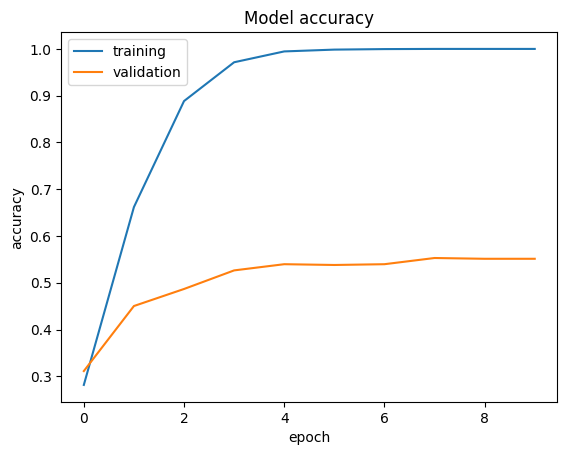

In [74]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

### APPROACH 2: Customised training loop
Using a more elaborate training loop for customising the training process. Customisations include:

- Changing the learning rate mid-process
- Keeping track of customised performance measure across training epochs
- Keeping track of and reverting (periodically, if applicable) to the the model with best validation performance

---

> REFERENCE: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

---

Customised training loop (**not executed due to time constraints**)...

```python
train_data = data_and_labels['train_data']
train_labels = data_and_labels['train_labels']
validation_data = data_and_labels['validation_data']
validation_labels = data_and_labels['validation_labels']
batch_size = data_params['batch_size']

# Building the model:
model = get_model()
# Fixing number of epochs:
epochs = 20
# Preparing the metrics:
train_acc_metric = keras.metrics.CategoricalAccuracy()
validation_acc_metric = keras.metrics.CategoricalAccuracy()

#================================================

train_accs_per_epoch = []
train_performances_per_epoch = []
validation_accs = []
validation_performances = []

best_validation_performance = 0
best_model_weights = model.get_weights() # Deep copy is not needed (check `model.get_weights` implementation to see why)

for epoch in range(epochs):
    print(f'\nEPOCH {epoch + 1}/{epochs}')
    print(f'Learning rate: {float(model.optimizer.learning_rate.value):.8f}')
    #------------------------------------
    # TRAINING LOOP
    
    # Iterating over the the dataset
    for step, (x, y) in enumerate(train_dataset):
        '''
        NEXT:
        Open a `GradientTape` to record the operations run during the
        forward pass, which enables auto-differentiation.
        '''
        # Running the forward pass of the layer:
        with tf.GradientTape() as tape:
            '''
            The operations that the layer applies to its inputs are going
            to be recorded on the GradientTape.
            '''
            logits = model(x, training=True)

            # Computing the loss value:
            loss_value = model.loss(y, logits)
            
        #________________________
        '''
        NEXT:
        Use the gradient tape to automatically retrieve the gradients of the
        trainable variables with respect to the loss.
        '''
        grads = tape.gradient(loss_value, model.trainable_weights)
        #________________________
        '''
        NEXT:
        Run one step of gradient descent by updating the value of the
        variables to minimize the loss.
        '''
        model.optimizer.apply(grads, model.trainable_weights)
        #________________________
        # Updating training metric:
        train_acc_metric.update_state(y, logits)

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    train_performance = get_performance(model, train_data, train_labels)

    train_accs_per_epoch.append(train_acc)
    train_performances_per_epoch.append(train_performance)
    
    print(f'Training accuracy & performance over epoch: {train_acc:.4f} & {train_performance:.4f}')

    # Resetting training metrics at the end of each epoch
    train_acc_metric.reset_state()
    
    #------------------------------------
    # VALIDATION LOOP
    
    # Running a validation loop at the end of each epoch:
    for x, y in validation_dataset:
        validation_logits = model(x, training=False)
        # Updating validation metrics:
        validation_acc_metric.update_state(y, validation_logits)
    validation_acc = validation_acc_metric.result()
    validation_performance = get_performance(model, validation_data, validation_labels)
    validation_acc_metric.reset_state()

    validation_accs.append(validation_acc)
    validation_performances.append(validation_performance)
    
    # Printing results:
    print(f'Validation accuracy & performance: {validation_acc:.4f} & {validation_performance:.4f}')

    # Updating best validation accuracy, performance and weights of the best model (best with respect to performance):
    if validation_performance > best_validation_performance:
        best_validation_performance = validation_performance
        best_model_weights = model.get_weights()
    
    # Every 5 epochs, check if current validation performance <= best validation performance
    # If so, halve the learning rate and revert to the best model so far...
    if (epoch + 1) % 5 == 0 and validation_performance <= best_validation_performance:
        model.set_weights(best_model_weights) # Deep copy is not needed (check `model.set_weights` implementation to see why)
        model.optimizer.learning_rate /= 2

#================================================
# Saving the model for later use:
save_model(model, 'storage/musicalKeyClassificationTrainedModelWeights_customisedLoop.npy')

#================================================
# Plotting the model's accuracy and performance (training and validation) across training epochs:
plt.plot(train_accs_per_epoch)
plt.plot(validation_accs)
plt.plot(train_performances_per_epoch)
plt.plot(validation_performances)
plt.title('Model accuracy & performance')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy', 'training performance', 'validation performance'])
plt.show()
```